<a href="https://colab.research.google.com/github/tranhuuan170302/source_code_model_and_statistical/blob/main/Model_BERTopic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mô tả cách thức xử lí<br>
### Bước 1: thực hiện đọc 1 file csv và lấy 2 cột chính là cột "Summary", "JobUrl".<br>
  + cột Summary: là cột mô tả công việc và yêu cầu, kinh nghiệm trong công việc.<br>
  + cột JobUrl: là cột tên công viêc.<br>


### Bước 2: Thực hiện tiền xử lí dữ liệu.<br>
  + xóa kí tự '\n'. <br>
  + Tạo một danh sách keyword (danh sách keyword này dựa theo thuật toán tf-idf để lựa chọn ra các danh sách các keyword mà em được cho là nó quan trọng nhất).<br>
  + Sau đó đơn giản hóa các keyword này đi ví dụ: programmer => program để có thể dễ lấy được dữ liệu một cách tổng quan nhất.<br>
  + Giá trị của cột Summary là một đoạn text. Vì vậy ta chia nhỏ ra thành các câu để dễ thực hiện việc xử lí dữ liệu theo keyword đông thời giúp mô hình BERTopic tốt hơn.<br>
  + Lọc dữ liệu từ các câu theo các keywords đã khởi tạo. Các câu có từ nằm trong keywords sẽ được giữ lại, các câu không có thì sẽ có giá trị None.<br>
  + các dòng mang giá trị None sẽ được xóa hết đi. Các câu có giá trị khác None sẽ được thực hiện xóa bỏ các từ stopword ví dụ: is, a, the, and,...<br>

    

### Bước 3: áp dụng mô hình BERTopic. Đây là mô hình thuật toán phân cụm. Thuật toán BERTopic trải qua 3 giao đoạn. <br>
  + Giai đoạn 1: Đọc tài liệu. Đầu vào sẽ là cột 'review_lemmatized' cột này đã được đi qua xử lí ở bước 2. BERTopic sẽ chuyển các câu này thày một vector.<br>
  + Bước 2: phân cụm tài liệu.<br>
    + Sau khi thực hiện giai đoạn 1 thì sẽ thực hiện mô hình phân cụm các câu dựa trên các vector này. Mô hình sẽ sử dụng UMAP (Uniform Manifold Approximation & Projection) là một thuật toán để giảm chiều dữ liệu (Mỗi topic đều được thể hiện thông qua một tập hợp các từ lại với nhau. Nhưng có một vài từ thì lại không có mang tính chất thể hiện nhiều. Vì vậy ta sử dụng thuật toán UMAP để giảm thiểu nó đi).<br>
  + Bước 3: Topic Representation.<br>
    + Sau khi mỗi câu đã được phân cụm rồi. Thì thuật toán sẽ áp một c-tf-idf dựa trên tf-idf để chọn ra nhưng từ quan trọng nhất trong câu để đại diện.<br>


### Bước 4: Thực hiện kiểm tra mô hình thông qua trực quan hóa dữ liệu. <br>

# Import libaries

In [1]:
# Install bertopic
!pip install bertopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 58.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     

In [2]:
# Data processing
import pandas as pd
import numpy as np

# Text preprocessiong
import nltk
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()

# Topic model
from bertopic import BERTopic

# Dimension reduction
from umap import UMAP

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [24]:
text = pd.read_csv('/content/drive/MyDrive/indeed/resultData.csv')

In [25]:
text.head()

Unnamed: 0                              JobTitle            Company  \
0           0                        .Net Developer           SmartDev   
1           1            Intern / Fresher Developer     DXC Technology   
2           2  .NET Developer (Middle/Senior level)              SIOUX   
3           3         Jun/Mid/Senior .NET Developer  Saigon Technology   
4           4     Web Developer (.NET, ASP.NET, C#)           NPV Corp   

                Location                      PostDate ExtractDate  \
0                Ðà Nẵng    Posted\nPosted 14 days ago  2023-01-25   
1  Thành phố Hồ Chí Minh  Employer\nActive 22 days ago  2023-01-25   
2                Ðà Nẵng   Posted\nPosted 30+ days ago  2023-01-25   
3                Ðà Nẵng    Posted\nPosted 18 days ago  2023-01-25   
4                Ðà Nẵng    Posted\nPosted 16 days ago  2023-01-25   

                                             Summary            JobUrl  
0  Company Description\nSmartDev is a leading pro...  .NET Developer\n  
1  Overview:\nHow would you like to join an inter...  .NET Developer\n  
2  Sioux Group was founded in 1996 in the Netherl...  .NET Developer\n  
3  Up to $2,200\nJunior, Middle, Senior\nDa Nang\...  .NET Developer\n  
4  Web Developer (.NET, ASP.NET, C#)\nNPV Corp\nỨ...  .NET Developer\n

In [26]:
review = text[['Summary', 'JobUrl']]

In [27]:
review.shape

(4379, 2)

In [28]:
review['Summary'] = review['Summary'].str.replace('\n', '')
review['JobUrl'] = review['JobUrl'].str.replace('\n', '')

In [29]:
# Remove stopwords
stopwords = nltk.corpus.stopwords.words('english')

In [30]:
review = review.reset_index()

In [31]:
review.head()

index                                            Summary          JobUrl
0      0  Company DescriptionSmartDev is a leading provi...  .NET Developer
1      1  Overview:How would you like to join an interna...  .NET Developer
2      2  Sioux Group was founded in 1996 in the Netherl...  .NET Developer
3      3  Up to $2,200Junior, Middle, SeniorDa NangFull-...  .NET Developer
4      4  Web Developer (.NET, ASP.NET, C#)NPV CorpỨng T...  .NET Developer

In [32]:
text['Summary'][0]

'Company Description\nSmartDev is a leading provider of global software solutions. The company was established in 2014 and is a wholly owned subsidiary of Verysell Technologies Group (Switzerland).\nSmartDev combines renowned Swiss quality with the Vietnamese passion to provide excellence and value. We brings together smart people both internally and externally to create partnerships that push boundaries and challenge the status quo.\nAs part of SmartDev’s aggressive growth plan we are looking to expand our development team, we (https://smartdev.com/) offers tailor-made mobile apps and websites with the most popular frontend and back-end technologies. We are currently works with about 140 developers.\n\nJob Description\n\nYou will report to PM (Project Manager)\nCollaborate with teams to product software design and architecture\nWrite clean, scalable code using .Net programming languages\nTest and deploy application and systems\nRevise, update, refactor and debugs code\nDevelop documen

In [33]:
import re
from nltk.stem import PorterStemmer
from nltk import pos_tag

In [34]:
# got these keywords by looking at some examples and using existing knowledge.
tool_keywords1 = ['sql', 'linqpad', 'teamcity', 'octopus', 'ncrunch', 'nuget', 'nunit', 'omnisharp', 'jetBrains rider', 'windbg', '.net reflector',
                  'reSharper', 'python', 'pytorch', 'sql', 'mxnet', 'mlflow', 'einstein', 'theano', 'pyspark', 'solr', 'mahout', 'html', 'css',
                  'cassandra', 'aws', 'powerpoint', 'spark', 'pig', 'sas', 'java', 'nosql', 'docker', 'salesforce', 'scala', 'r',
                  'c', 'c++', 'net', 'tableau', 'pandas', 'scikitlearn', 'sklearn', 'matlab', 'scala', 'keras', 'tensorflow', 'clojure',
                  'caffe', 'scipy', 'numpy', 'matplotlib', 'vba', 'spss', 'linux', 'azure', 'cloud', 'gcp', 'mongodb', 'mysql', 'oracle', 
                  'redshift', 'snowflake', 'kafka', 'javascript', 'qlik', 'jupyter', 'perl', 'bigquery', 'unix', 'react',
                  'scikit', 'powerbi', 's3', 'ec2', 'lambda', 'ssrs', 'kubernetes', 'hana', 'spacy', 'tf', 'django', 'sagemaker',
                  'seaborn', 'mllib', 'github', 'git', 'elasticsearch', 'splunk', 'airflow', 'looker', 'rapidminer', 'birt', 'pentaho', 
                  'jquery', 'nodejs', 'd3', 'plotly', 'bokeh', 'xgboost', 'rstudio', 'shiny', 'dash', 'h20', 'h2o', 'hadoop', 'mapreduce', 
                  'hive', 'cognos', 'angular', 'nltk', 'flask', 'node', 'firebase', 'bigtable', 'rust', 'php', 'cntk', 'lightgbm', 
                  'kubeflow', 'rpython', 'unixlinux', 'postgressql', 'postgresql', 'postgres', 'hbase', 'dask', 'ruby', 'julia', 'tensor',
                  # added r packages doesn't seem to impact the result
                  'dplyr','ggplot2','esquisse','bioconductor','shiny','lubridate','knitr','mlr','quanteda','dt','rcrawler','caret','rmarkdown',
                  'leaflet','janitor','ggvis','plotly','rcharts','rbokeh','broom','stringr','magrittr','slidify','rvest',
                  'rmysql','rsqlite','prophet','glmnet','text2vec','snowballc','quantmod','rstan','swirl','datasciencer', 'amazon web services', 'google cloud', 'sql server',
                  
                  
                  
                'statistics', 'cleansing', 'chatbot', 'cleaning', 'blockchain', 'causality', 'correlation', 'bandit', 'anomaly',
                'dashboard', 'geospatial', 'ocr', 'econometrics', 'pca', 'gis', 'svm', 'svd', 'tuning', 'hyperparameter', 'hypothesis',
                'salesforcecom', 'segmentation', 'biostatistics', 'unsupervised', 'supervised', 'exploratory',
                'recommender', 'recommendations', 'research', 'sequencing', 'probability', 'reinforcement', 'graph', 'bioinformatics',
                'chi', 'knn', 'outlier', 'etl', 'normalization', 'classification', 'optimizing', 'prediction', 'forecasting',
                'clustering', 'cluster', 'optimization', 'visualization', 'nlp', 'c#', 'negotiation', 'self learning', 
                'regression', 'logistic', 'nn', 'cnn', 'glm', 'sloving', 'ux ui', 'teamwork', 'creative thinking',
                'rnn', 'lstm', 'gbm', 'boosting', 'recurrent', 'convolutional', 'bayesian',
                'bayes', 'random forest', 'natural language processing', 'machine learning', 'decision tree', 'deep learning', 'experimental design',
                'time series', 'nearest neighbors', 'neural network', 'support vector machine', 'computer vision', 'machine vision', 'dimensionality reduction', 
                'text analytics', 'power bi', 'a/b testing', 'ab testing', 'chat bot', 'data mining',
                
                
                'bs', 'bachelor', 'undergraduate', 'certificate',
               'master', 'graduate', 'mba', 'intermediate',
               'phd', 'ph.d', 'ba', 'ma', 'it',
               'postdoctoral', 'postdoc', 'doctorate', 'new graduate', 'đại học']


In [35]:
ps = PorterStemmer()
tool_keywords1_set = set([ps.stem(tok) for tok in tool_keywords1])

In [36]:

df = pd.DataFrame(columns = ['index', 'review'])
for idx in review.index.unique():
  string = review['Summary'][idx]
  string = string.split('.')
  id = []
  txt = []
  
  for st in string:
    id.append(idx)
    txt.append(st)
    datax = pd.DataFrame(list(zip(id, txt)), columns = ['index', 'review'])
  df = pd.concat([df, datax])

In [37]:
df.head(15)

index                                             review
0      0  Company DescriptionSmartDev is a leading provi...
1      0   The company was established in 2014 and is a ...
2      0  SmartDev combines renowned Swiss quality with ...
3      0   We brings together smart people both internal...
4      0  As part of SmartDev’s aggressive growth plan w...
5      0  com/) offers tailor-made mobile apps and websi...
6      0   We are currently works with about 140 developers
7      0  Job DescriptionYou will report to PM (Project ...
8      0  Net programming languagesTest and deploy appli...
9      0                  Net DeveloperBe familiar with ASP
10     0  NET framework, SQL Server and design/ architec...
11     0                   Net languages (C#, Visual Basic 
12     0  Net), and HTML5/ CSS3Be familiar with architec...
0      1  Overview:How would you like to join an interna...
1      1  NET/JavaScript/DevOps/ ServiceNow /AI/ Cobol t...

In [38]:
review.head()

index                                            Summary          JobUrl
0      0  Company DescriptionSmartDev is a leading provi...  .NET Developer
1      1  Overview:How would you like to join an interna...  .NET Developer
2      2  Sioux Group was founded in 1996 in the Netherl...  .NET Developer
3      3  Up to $2,200Junior, Middle, SeniorDa NangFull-...  .NET Developer
4      4  Web Developer (.NET, ASP.NET, C#)NPV CorpỨng T...  .NET Developer

In [39]:
# merger data by index
review = review.merge(df, left_on = 'index', right_on = 'index')

In [40]:
review.shape

(84890, 4)

In [41]:
review = review.loc[review.duplicated() == False, :]

In [42]:
#find sentences with words in tool_keyword list
def filterString(string):
  item = string.split(' ')
  stemmed_tokens = [ps.stem(tok).lower() for tok in item]
  for st in stemmed_tokens:
    if tool_keywords1_set.__contains__(st):
      return string
  return None

In [43]:
review['review_filter'] = review['review'].apply(lambda string: filterString(string))

In [44]:
review['review_filter'].isna().sum()

64419

In [45]:
review.dropna(inplace=True)

In [46]:
review.isna().sum()

index            0
Summary          0
JobUrl           0
review           0
review_filter    0
dtype: int64

In [47]:
# Remove stopwords
review['Summary_without_stopwords'] = review['review'].apply(lambda x: ' '.join([w for w in x.split() if w.lower() not in stopwords]))

# Lemmatization
review['review_lemmatized'] = review['Summary_without_stopwords'].apply(lambda x: ' '.join([wn.lemmatize(w) for w in x.split() if w not in stopwords]))

# Take a look at the data
review.head()

index                                            Summary          JobUrl  \
8      0  Company DescriptionSmartDev is a leading provi...  .NET Developer   
9      0  Company DescriptionSmartDev is a leading provi...  .NET Developer   
10     0  Company DescriptionSmartDev is a leading provi...  .NET Developer   
11     0  Company DescriptionSmartDev is a leading provi...  .NET Developer   
12     0  Company DescriptionSmartDev is a leading provi...  .NET Developer   

                                               review  \
8   Net programming languagesTest and deploy appli...   
9                   Net DeveloperBe familiar with ASP   
10  NET framework, SQL Server and design/ architec...   
11                   Net languages (C#, Visual Basic    
12  Net), and HTML5/ CSS3Be familiar with architec...   

                                        review_filter  \
8   Net programming languagesTest and deploy appli...   
9                   Net DeveloperBe familiar with ASP   
10  NET framework, SQL Server and design/ architec...   
11                   Net languages (C#, Visual Basic    
12  Net), and HTML5/ CSS3Be familiar with architec...   

                            Summary_without_stopwords  \
8   Net programming languagesTest deploy applicati...   
9                        Net DeveloperBe familiar ASP   
10  NET framework, SQL Server design/ architectura...   
11                    Net languages (C#, Visual Basic   
12  Net), HTML5/ CSS3Be familiar architecture styl...   

                                    review_lemmatized  
8   Net programming languagesTest deploy applicati...  
9                        Net DeveloperBe familiar ASP  
10  NET framework, SQL Server design/ architectura...  
11                     Net language (C#, Visual Basic  
12  Net), HTML5/ CSS3Be familiar architecture styl...

In [48]:
review.isna().sum()

index                        0
Summary                      0
JobUrl                       0
review                       0
review_filter                0
Summary_without_stopwords    0
review_lemmatized            0
dtype: int64

In [49]:
review = review.loc[review.duplicated() == False, :]

In [50]:
review = review.reset_index()

In [52]:
review.shape

(16723, 8)

In [53]:
# Initiate UMAP to dimension reduction.
umap_model = UMAP(n_neighbors=15, 
                  n_components=5, 
                  min_dist=0.0, 
                  metric='cosine', 
                  random_state=100)

# Initiate BERTopic
topic_model = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=True)

# Run BERTopic model
topics, probabilities = topic_model.fit_transform(review['review_lemmatized'])

In [54]:
# Get the list of topics
topic_model.get_topic_info()

Topic  Count                                               Name
0       -1   2828                          -1_data_business_vin_kinh
1        0    464                         0_thiuvic_clientl_tphcm_nc
2        1    460                                    1_ch_du_phc_khi
3        2    457             2_remote_rails_nnmanyear_developerupto
4        3     98  3_core_interfacestay_troubleshootingmaintain_c...
..     ...    ...                                                ...
540    539     11  539_mid_jobable_pressureresponsibilitiesat_ful...
541    540     11        540_jira_processyu_mmphppythoni_backendcntt
542    541     11                              541_cloud_amazon_aws_
543    542     10                               542_nodejs_vai_vi_02
544    543     10            543_x10niteco_co_2700reflex_2023simpson

[545 rows x 3 columns]

In [55]:
# Get top 10 terms for a topic
topic_model.get_topic(0)

[('thiuvic', 0.04960018961151188),
 ('clientl', 0.04960018961151188),
 ('tphcm', 0.04892386589738353),
 ('nc', 0.04603130161556595),
 ('ngoi', 0.04401593520721079),
 ('lnh', 0.042322367791007655),
 ('100', 0.040585449498882854),
 ('hot', 0.038326622046454664),
 ('vc', 0.037451167030744144),
 ('mm', 0.035071583572994044)]

In [56]:
# Visualize top topic keywords
topic_model.visualize_barchart(top_n_topics=20)

In [57]:
# Visualize term rank decrease
topic_model.visualize_term_rank()

In [58]:
# Visualize intertopic distance
topic_model.visualize_topics()

In [59]:
# Visualize connections between topics using hierachical clustering
topic_model.visualize_hierarchy(top_n_topics=15)

In [60]:
# Visualize similarity using heatmap
topic_model.visualize_heatmap()

In [64]:
# Check the content for the first review
review['review'][0]

'Net programming languagesTest and deploy application and systemsRevise, update, refactor and debugs codeDevelop documentation throughout the software development life cycleParticipate in code reviewsTrain fellow colleaguesQualificationsProven 3+ years of work experience as a '

In [65]:
# Get probabilities for all topics
topic_model.probabilities_[0][:30]

array([4.10280485e-06, 4.11397953e-06, 4.49385218e-06, 5.05185970e-06,
       4.59913799e-06, 1.41457012e-05, 8.78099091e-06, 3.88535293e-06,
       8.58871686e-06, 4.77661681e-06, 8.59960234e-06, 5.48690420e-06,
       1.58406957e-05, 1.13668977e-05, 8.06988076e-06, 1.41387917e-05,
       9.02557953e-06, 1.80711601e-05, 1.02490765e-05, 4.84494433e-06,
       1.55865566e-05, 6.49670433e-06, 5.96189120e-06, 1.56657862e-05,
       1.56840755e-05, 7.82087700e-06, 5.02044874e-06, 1.27766914e-05,
       1.75702106e-05, 4.23443394e-06])

In [66]:
# Get the topic predictions
topic_prediction = topic_model.topics_[:]

# Save the predictions in the dataframe
review['topic_prediction'] = topic_prediction

# Take a look at the data
review.head()

level_0 index                                            Summary  \
0        8     0  Company DescriptionSmartDev is a leading provi...   
1        9     0  Company DescriptionSmartDev is a leading provi...   
2       10     0  Company DescriptionSmartDev is a leading provi...   
3       11     0  Company DescriptionSmartDev is a leading provi...   
4       12     0  Company DescriptionSmartDev is a leading provi...   

           JobUrl                                             review  \
0  .NET Developer  Net programming languagesTest and deploy appli...   
1  .NET Developer                  Net DeveloperBe familiar with ASP   
2  .NET Developer  NET framework, SQL Server and design/ architec...   
3  .NET Developer                   Net languages (C#, Visual Basic    
4  .NET Developer  Net), and HTML5/ CSS3Be familiar with architec...   

                                       review_filter  \
0  Net programming languagesTest and deploy appli...   
1                  Net DeveloperBe familiar with ASP   
2  NET framework, SQL Server and design/ architec...   
3                   Net languages (C#, Visual Basic    
4  Net), and HTML5/ CSS3Be familiar with architec...   

                           Summary_without_stopwords  \
0  Net programming languagesTest deploy applicati...   
1                       Net DeveloperBe familiar ASP   
2  NET framework, SQL Server design/ architectura...   
3                    Net languages (C#, Visual Basic   
4  Net), HTML5/ CSS3Be familiar architecture styl...   

                                   review_lemmatized  topic_prediction  
0  Net programming languagesTest deploy applicati...                37  
1                       Net DeveloperBe familiar ASP               312  
2  NET framework, SQL Server design/ architectura...               278  
3                     Net language (C#, Visual Basic               123  
4  Net), HTML5/ CSS3Be familiar architecture styl...               199

In [ ]:
# New data for the review
new_review = "Having experience with Programing Language such as R Python Report/dashboard visualization Tableau Power BI Qlik is a plus."
new_review1 = 'có khả năng sử dụng javascript, java, docker, support, design'
# Find topics
num_of_topics = 3
similar_topics, similarity = topic_model.find_topics(new_review1, top_n=num_of_topics); 

# Print results
print(f'The top {num_of_topics} similar topics are {similar_topics}, and the similarities are {np.round(similarity,2)}')

The top 3 similar topics are [193, 110, 501], and the similarities are [0.45 0.44 0.44]


In [ ]:
# Print the top keywords for the top similar topics
for i in range(num_of_topics):
  print(f'The top keywords for topic {similar_topics[i]} are:')
  print(topic_model.get_topic(similar_topics[i]))

The top keywords for topic 193 are:
[('tuynnodejs', 0.04722925579266279), ('nodejsjavalecle', 0.032258000877832566), ('providedchallenges', 0.032258000877832566), ('lovemacbook', 0.032258000877832566), ('technologiesm', 0.0277417843987606), ('javang', 0.027152366578438683), ('lng81', 0.02511992928914122), ('cuttingedge', 0.02087608505385793), ('outsourcing', 0.019870682709456133), ('phng36', 0.01974137910399003)]
The top keywords for topic 110 are:
[('dev', 0.05811350451960407), ('tuynhtml5', 0.05799266791096664), ('javascriptng', 0.036985600038241), ('102', 0.032152121225060684), ('html5css3javascriptsolis', 0.032152121225060684), ('vicsolis', 0.032152121225060684), ('designbonuses', 0.032152121225060684), ('html5css3javascript', 0.032152121225060684), ('individualsskill', 0.032152121225060684), ('labng', 0.032152121225060684)]
The top keywords for topic 501 are:
[('angularjs', 0.15596346438749917), ('ui', 0.14092106642385488), ('reactjs', 0.1021916983053206), ('js', 0.094998999984949

In [ ]:
# merge list job by topics
list_job = []
for i in range(num_of_topics):
  name =review.loc[review['topic_prediction'] == similar_topics[i],  'JobUrl']
  job = name.tolist()
  list_job += job
print(list_job)

['.NET Developer', '.NET Developer', 'Android App Developer', 'Android Developer', 'Back End Developer', 'Back End Developer', 'Back End Developer', 'Back End Developer', 'Back End Developer', 'Back End Developer', 'Back End Web Developer', 'Front End Developer', 'Front End Developer', 'Front End Developer', 'Front End Developer', 'Front End Developer', 'Front End Developer', 'Front End Web Developer', 'Front End Web Developer', 'Full Stack Developer', 'Full Stack Developer', 'Full Stack Developer', 'Full Stack Web Developer', 'Android Developer', 'Android Developer', 'Back End Developer', 'Back End Developer', 'Back End Developer', 'Back End Developer', 'Back End Web Developer', 'Back End Web Developer', 'Back End Web Developer', 'Back End Web Developer', 'Back End Web Developer', 'Bridge Engineer', 'Front End Developer', 'Front End Developer', 'Front End Developer', 'Front End Developer', 'Front End Developer', 'Front End Developer', 'Front End Developer', 'Front End Developer', 'Fro

In [ ]:
# check the most appearing job
def most_frequent(List):
    return max(set(List), key = List.count)


In [ ]:
most_frequent(list_job)

'Front End Developer'

In [71]:
import collections

In [ ]:
collections.Counter(list_job).values()

dict_values([3, 1, 3, 11, 7, 18, 11, 6, 5, 1])

In [73]:
import matplotlib.pyplot as plt

In [69]:
def show_job_suitable(list_job_user):
  val = collections.Counter(list_job_user)
  vals = []
  for i in list(val.values()):
    vals.append(i*100/sum(list(val.values())))

  # Figure Size
  fig, ax = plt.subplots(figsize =(16, 9))
  
  # Horizontal Bar Plot
  ax.barh(list(val.keys()), vals)
  
  # Remove axes splines
  for s in ['top', 'bottom', 'left', 'right']:
      ax.spines[s].set_visible(False)
  
  # Remove x, y Ticks
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')
  
  # Add padding between axes and labels
  ax.xaxis.set_tick_params(pad = 5)
  ax.yaxis.set_tick_params(pad = 10)
  
  # Add x, y gridlines
  ax.grid(b = True, color ='grey',
          linestyle ='-.', linewidth = 0.5,
          alpha = 0.2)
  
  # Show top values
  ax.invert_yaxis()
  
  # Add annotation to bars
  for i in ax.patches:
      plt.text(i.get_width()+0.2, i.get_y()+0.5,
              str(round((i.get_width()), 2)),
              fontsize = 10, fontweight ='bold',
              color ='grey')
  
  
  # Add Text watermark
  fig.text(0.9, 0.15, 'tranhuuan', fontsize = 12,
          color ='grey', ha ='right', va ='bottom',
          alpha = 0.7)
  # Show Plot
  plt.show()

<ipython-input-50-af896db5adfa>:26: MatplotlibDeprecationWarning:

The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.



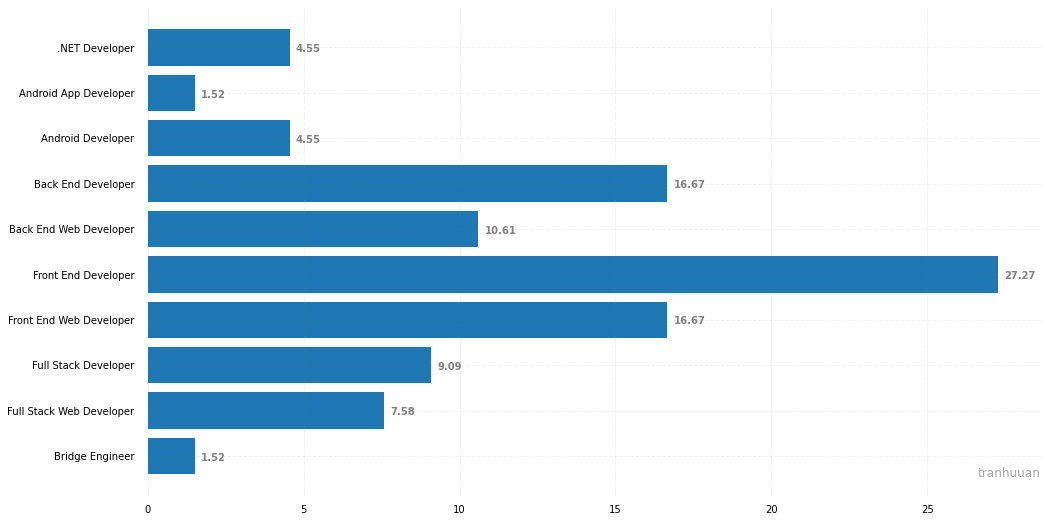

In [ ]:
show_job_suitable(list_job)

Input: 'có khả năng sử dụng javascript, java, docker, support, design'

# Save model BERTopics

In [ ]:
# Save model
# topic_model.save("my_model")

/usr/local/lib/python3.9/dist-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [22]:
my_model = BERTopic.load("/content/drive/MyDrive/indeed/my_model")

# Test model BERTopics

In [76]:
test = '''Data Cleaning & Exploration using Python, Data Modifying & Visualization using Microsoft Excel, Data Modifying & Visualization using Microsoft Excel
        Database Administrating using SQL Server'''

In [78]:
def showResult(test):
  # handle string.
  test = re.sub(r"[!#$%&'()*+,-./:;<=>?@[\]^_`{|}~]", '', test)
  test = test.replace('\n', '')
  tesst = test.lower()
  
  num_of_topics = 3
  similar_topics, similarity = topic_model.find_topics(tesst, top_n=num_of_topics); 

  # Print results
  #print(f'The top {num_of_topics} similar topics are {similar_topics}, and the similarities are {np.round(similarity,2)}')
  # merge list job by topics
  list_job = []
  for i in range(num_of_topics):
    name =review.loc[review['topic_prediction'] == similar_topics[i],  'JobUrl']
    job = name.tolist()
    list_job += job
  #print(list_job)
  show_job_suitable(list_job)

<ipython-input-69-af896db5adfa>:26: MatplotlibDeprecationWarning:

The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.



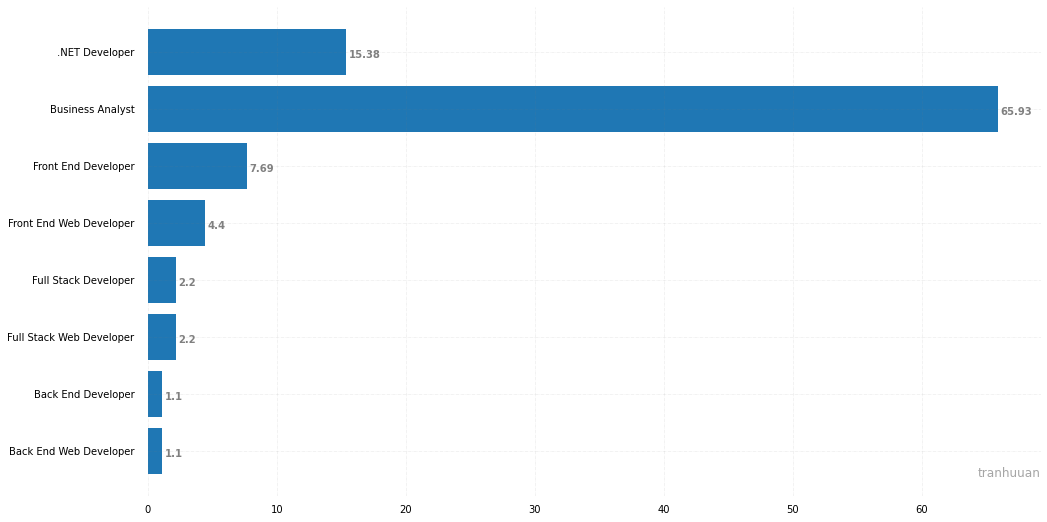

In [79]:
showResult(test)